<a href="https://colab.research.google.com/github/R-Ireri/R-Ireri/blob/main/DDI_Advanced_Healthcare_NBI_Accessibility_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from geopy.distance import geodesic
sns.set(style='whitegrid')

In [ ]:
# Install necessary libraries for geospatial analysis
%pip install geopandas folium matplotlib seaborn

print("Geospatial analysis libraries installed.")

Geospatial analysis libraries installed.


# Upload Analysis Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kenya-population-land-area-population-density_by_county.csv to kenya-population-land-area-population-density_by_county.csv
Saving ehealth-kenya-facilities-download-21102015.csv to ehealth-kenya-facilities-download-21102015.csv
Saving kenya-average-household-size-by-sub-county.csv to kenya-average-household-size-by-sub-county.csv
Saving kenya-population-by-sex-and-county.csv to kenya-population-by-sex-and-county.csv
Saving kenya-population-by-sub-county.csv to kenya-population-by-sub-county.csv


# Load All Datasets


Subtask:
Load the health facilities data and population data into pandas DataFrames.

In [ ]:
import pandas as pd

# # Load population by sub-county
pop_df = pd.read_csv('kenya-population-by-sub-county.csv')

# # Load gender population
sex_df = pd.read_csv('kenya-population-by-sex-and-county.csv')

# # Load household size
house_df = pd.read_csv('kenya-average-household-size-by-sub-county.csv')

# Load health facilities
facilities_df = pd.read_csv('ehealth-kenya-facilities-download-21102015.csv')

# Filter for Nairobi in facilities_df
facilities_nairobi = facilities_df[facilities_df['County'] == 'Nairobi']

# Load the population density data, skipping the initial rows to get the correct header
population_density_df = pd.read_csv("/content/kenya-population-land-area-population-density_by_county.csv")

# Display the first few rows to understand its structure
print("Population Density Data Head after skipping rows:")
display(population_density_df.head())

# Inspect columns to understand the structure and identify relevant columns
print("\nPopulation Density Data Columns after skipping rows:")
print(population_density_df.columns)

# Filter for Nairobi in pop_df (assuming 'Name of City' column contains county/sub-county information)
pop_nairobi = pop_df[pop_df['Name of City'].str.contains('Nairobi', na=False)]

Population Density Data Head after skipping rows:


,Name,Population,Land Area (Sq. Km),Population Density (No. per Sq. Km)
0,Kenya,47564296,580876.3,82
1,Mombasa,1208333,219.9,5495
2,Kwale,866820,8267.1,105
3,Kilifi,1453787,12539.7,116
4,Tana River,315943,37950.5,8



Population Density Data Columns after skipping rows:
Index(['Name', 'Population', 'Land Area (Sq. Km)',
       'Population Density (No. per Sq. Km)'],
      dtype='object')


In [ ]:
# Load the population density data with no header
population_density_df = pd.read_csv("/content/kenya-population-land-area-population-density_by_county.csv", header=None)

# Display the first few rows to understand its structure and identify the header row
print("Population Density Data Head after loading with no header:")
display(population_density_df.head())

# Manually set the column names based on the expected header row
population_density_df.columns = ['name', 'population', 'land_area_sq_km', 'population_density_no_per_sq_km']

# Drop the first row which contains the actual header
population_density_df = population_density_df[1:].copy()

# Clean column names: lowercase, replace spaces with underscores, remove special characters
population_density_df.columns = population_density_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)


# Display column names after setting new header and cleaning
print("\nPopulation Density Data Columns after setting new header and cleaning:")
print(population_density_df.columns)
display(population_density_df.head())


# Rename columns for clarity
# Based on the output above, the column names should now be: 'name', 'population', 'land_area_sq_km', 'population_density_no_per_sq_km'
population_density_df.rename(columns={'land_area_sq_km': 'land_area', 'population_density_no_per_sq_km': 'population_density'}, inplace=True)


# Convert population, land_area and population_density to numeric, coercing errors
population_density_df['population'] = pd.to_numeric(population_density_df['population'], errors='coerce')
population_density_df['land_area'] = pd.to_numeric(population_density_df['land_area'], errors='coerce')
population_density_df['population_density'] = pd.to_numeric(population_density_df['population_density'], errors='coerce')


# Display renamed and cleaned columns and data types
print("\nPopulation Density Data after renaming and cleaning:")
display(population_density_df.head())
print("\nRenamed and Cleaned Population Density Data Columns:")
print(population_density_df.columns)
print("\nData types after conversion:")
display(population_density_df.dtypes)


# Filter for Nairobi county in the population density data
nairobi_population_density = population_density_df[population_density_df['name'] == 'Nairobi'].copy()

print("\nPopulation Density Data for Nairobi County:")
display(nairobi_population_density)

Population Density Data Head after loading with no header:


,0,1,2,3
0,Name,Population,Land Area (Sq. Km),Population Density (No. per Sq. Km)
1,Kenya,47564296,580876.3,82
2,Mombasa,1208333,219.9,5495
3,Kwale,866820,8267.1,105
4,Kilifi,1453787,12539.7,116



Population Density Data Columns after setting new header and cleaning:
Index(['name', 'population', 'land_area_sq_km',
       'population_density_no_per_sq_km'],
      dtype='object')


,name,population,land_area_sq_km,population_density_no_per_sq_km
1,Kenya,47564296,580876.3,82
2,Mombasa,1208333,219.9,5495
3,Kwale,866820,8267.1,105
4,Kilifi,1453787,12539.7,116
5,Tana River,315943,37950.5,8



Population Density Data after renaming and cleaning:


,name,population,land_area,population_density
1,Kenya,47564296,580876.3,82
2,Mombasa,1208333,219.9,5495
3,Kwale,866820,8267.1,105
4,Kilifi,1453787,12539.7,116
5,Tana River,315943,37950.5,8



Renamed and Cleaned Population Density Data Columns:
Index(['name', 'population', 'land_area', 'population_density'], dtype='object')

Data types after conversion:


,0
name,object
population,int64
land_area,float64
population_density,int64



Population Density Data for Nairobi County:


,name,population,land_area,population_density
48,Nairobi,4397073,703.9,6247


# Data Cleaning and Preparation

### Subtask:
Clean column names, ensure data types are appropriate, handle missing values, and standardize location names in both datasets.

Reasoning: Clean column names by removing leading/trailing spaces and converting to lowercase for consistency. Inspect data types and convert where necessary. Check for missing values in crucial columns and decide on an appropriate handling strategy (e.g., imputation, removal). Standardize district/sub-county names to ensure they match for merging.

In [ ]:
# # Standardize all column names: lowercase, underscores, no spaces
def clean_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('.', '', regex=False)
    )
    return df

# Apply to each DataFrame
facilities_df = clean_columns(facilities_df)
pop_df = clean_columns(pop_df)
sex_df = clean_columns(sex_df)
house_df = clean_columns(house_df)
population_density_df = clean_columns(population_density_df)

In [ ]:
# Inspect data types and missing values for facilities_df
print("Data types for facilities_df:")
display(facilities_df.dtypes)

print("\nMissing values per column for facilities_df:")
display(facilities_df.isnull().sum())

# Inspect data types and missing values for pop_df
print("\nData types for pop_df:")
display(pop_df.dtypes)

print("\nMissing values per column for pop_df:")
display(pop_df.isnull().sum())

Data types for facilities_df:


,0
facility_code,int64
facility_name,object
province,object
county,object
district,object
division,object
type,object
owner,object
location,object
sub_location,object



Missing values per column for facilities_df:


,0
facility_code,0
facility_name,0
province,0
county,0
district,0
division,267
type,0
owner,0
location,495
sub_location,892



Data types for pop_df:


,0
name_of_city,object
male,int64
female,int64
intersex,float64
total,int64
unnamed:_5,float64
unnamed:_6,float64
unnamed:_7,float64
unnamed:_8,float64
unnamed:_9,float64



Missing values per column for pop_df:


,0
name_of_city,0
male,0
female,0
intersex,45
total,0
unnamed:_5,393
unnamed:_6,393
unnamed:_7,393
unnamed:_8,393
unnamed:_9,393


In [ ]:
# Handle missing values in facilities_df
facilities_df['beds'] = facilities_df['beds'].fillna(0)
facilities_df['cots'] = facilities_df['cots'].fillna(0)

# Handle missing values in pop_df
pop_df['intersex'] = pop_df['intersex'].fillna(0)

# Drop unnamed columns in pop_df
pop_df = pop_df.drop(columns=[col for col in pop_df.columns if 'unnamed' in col])

print("Missing values handled and irrelevant columns dropped.")
print("\nMissing values per column for facilities_df after handling:")
display(facilities_df.isnull().sum())
print("\nMissing values per column for pop_df after handling:")
display(pop_df.isnull().sum())

Missing values handled and irrelevant columns dropped.

Missing values per column for facilities_df after handling:


,0
facility_code,0
facility_name,0
province,0
county,0
district,0
division,267
type,0
owner,0
location,495
sub_location,892



Missing values per column for pop_df after handling:


,0
name_of_city,0
male,0
female,0
intersex,0
total,0


In [ ]:
# Inspect unique values in location columns for standardization
print("Unique counties in facilities_df:")
display(facilities_df['county'].unique())

print("\nUnique districts in facilities_df:")
display(facilities_df['district'].unique())

print("\nUnique names of city in pop_df:")
display(pop_df['name_of_city'].unique())

Unique counties in facilities_df:


array(['Embu', 'Nairobi', 'Laikipia', 'Kiambu', 'Kajiado', 'Nakuru',
       'Isiolo', 'Uasin Gishu', 'Kisumu', 'Mombasa', 'Kilifi', 'Garissa',
       'Kirinyaga', 'Tharaka Nithi', 'Kitui', 'Nyandarua', 'Trans Nzoia',
       'Nyeri', 'Turkana', 'Taita Taveta', 'Mandera', 'Migori', 'Vihiga',
       'Samburu', 'Makueni', 'Baringo', 'Machakos', 'Bungoma', 'Kakamega',
       'Homa Bay', 'Siaya', 'Busia', 'Nyamira', 'West Pokot', 'Wajir',
       'Meru', 'Narok', 'Lamu', "Murang'a", 'Nandi', 'Kericho',
       'Marsabit', 'Bomet', 'Tana River', 'Elgeyo Marakwet', 'Kisii',
       'Kwale'], dtype=object)


Unique districts in facilities_df:


array(['Manyatta', 'Mathare', 'Laikipia East', 'Thika West',
       'Kajiado North', 'Nakuru', 'Isiolo', 'Langata', 'Njoro', 'Kibra',
       'Starehe', 'Westlands', 'Eldoret West', 'Dagoretti North',
       'Embakasi East', 'Kisumu East', 'Ruaraka', 'Mvita', 'Roysambu',
       'Garbatula', 'Kilifi North', 'Kamukunji', 'Lagdera', 'Garissa',
       'Kirinyaga North', 'Meru South', 'Mutomo', 'Githunguri',
       'Nyandarua West', 'Trans Nzoia West', 'Kirinyaga East', 'Magarini',
       'Mirangine', 'Nyeri Central', 'Turkana Central', 'Wundanyi',
       'Mandera East', 'Migori', 'Tetu', 'Sabatia', 'Samburu Central',
       'Kibwezi', 'Koibatek', 'Kajiado Central', 'Masinga',
       'Bungoma South', 'Mumias West', 'Rachuonyo North', 'Gem',
       'Teso South', 'Teso North', 'Manga', 'North Pokot', 'Kikuyu',
       'Mathira East', 'Rachuonyo South', 'Athi River', 'Wajir West',
       'Igembe Central', 'Baringo North', 'Nyeri South',
       'Kakamega Central (Lurambi)', 'Makadara', 'Nyando', 


Unique names of city in pop_df:


array(['Kenya', 'Mombasa', 'Changamwe ', 'Jomvu ', 'Kisauni', 'Likoni ',
       'Mvita ', 'Nyali ', 'Kwale  ', 'Kinango ', 'Lungalunga',
       'Matuga      ', 'Ms am bweni    ', 'Samburu-Kwale     ',
       'Kilifi       ', 'Chonyi      ', 'Ganze    .    ',
       'Kaloleni.     ', 'Kauma      ', 'Kilifi North       ',
       'Kilifi South    ', 'Magarini     ', 'Malindi        ',
       'Rabai        ', 'Tana River      ', 'Tana North ',
       'Tana Delta       ', 'Tana River       ', 'Lamu        ',
       'Lamu East.    ', 'Lamu West.      ', 'Taita/Taveta     ',
       'Mwatate     ', 'Taita         ', 'Taveta      ', 'Voi       ',
       'Garissa       ', 'Balambala', 'Dadaab.      ', 'Fafi        ',
       'Garissa      ', 'Hulugho      ', 'Ijara .      ', 'Lagdera    ',
       'Wajir        ', 'Buna        ', 'Eldas       ', 'Habaswein     ',
       'Tarbaj       ', 'Wajir East      ', 'Wajir North     ',
       'Wajir South     ', 'Wajir West     ', 'Mandera       ',
       '

In [ ]:
# Standardize county names in facilities_df
facilities_df['county'] = facilities_df['county'].str.strip().str.title()

# Standardize district names in facilities_df (handle missing values before stripping)
facilities_df['district'] = facilities_df['district'].fillna('').str.strip().str.title()

# Standardize name_of_city in pop_df
pop_df['name_of_city'] = pop_df['name_of_city'].str.strip().str.title()

# Manual mapping for known inconsistencies (add more as needed after review)
location_mapping = {
    'Nairobi City': 'Nairobi',
    # Add other mappings as identified from the unique values
}

facilities_df['county'] = facilities_df['county'].replace(location_mapping)
facilities_df['district'] = facilities_df['district'].replace(location_mapping)
pop_df['name_of_city'] = pop_df['name_of_city'].replace(location_mapping)

print("Location names standardized.")

# Verify standardization (optional - display unique values again)
print("\nUnique counties in facilities_df after standardization:")
display(facilities_df['county'].unique())

print("\nUnique districts in facilities_df after standardization:")
display(facilities_df['district'].unique())

print("\nUnique names of city in pop_df after standardization:")
display(pop_df['name_of_city'].unique())

Location names standardized.

Unique counties in facilities_df after standardization:


array(['Embu', 'Nairobi', 'Laikipia', 'Kiambu', 'Kajiado', 'Nakuru',
       'Isiolo', 'Uasin Gishu', 'Kisumu', 'Mombasa', 'Kilifi', 'Garissa',
       'Kirinyaga', 'Tharaka Nithi', 'Kitui', 'Nyandarua', 'Trans Nzoia',
       'Nyeri', 'Turkana', 'Taita Taveta', 'Mandera', 'Migori', 'Vihiga',
       'Samburu', 'Makueni', 'Baringo', 'Machakos', 'Bungoma', 'Kakamega',
       'Homa Bay', 'Siaya', 'Busia', 'Nyamira', 'West Pokot', 'Wajir',
       'Meru', 'Narok', 'Lamu', "Murang'A", 'Nandi', 'Kericho',
       'Marsabit', 'Bomet', 'Tana River', 'Elgeyo Marakwet', 'Kisii',
       'Kwale'], dtype=object)


Unique districts in facilities_df after standardization:


array(['Manyatta', 'Mathare', 'Laikipia East', 'Thika West',
       'Kajiado North', 'Nakuru', 'Isiolo', 'Langata', 'Njoro', 'Kibra',
       'Starehe', 'Westlands', 'Eldoret West', 'Dagoretti North',
       'Embakasi East', 'Kisumu East', 'Ruaraka', 'Mvita', 'Roysambu',
       'Garbatula', 'Kilifi North', 'Kamukunji', 'Lagdera', 'Garissa',
       'Kirinyaga North', 'Meru South', 'Mutomo', 'Githunguri',
       'Nyandarua West', 'Trans Nzoia West', 'Kirinyaga East', 'Magarini',
       'Mirangine', 'Nyeri Central', 'Turkana Central', 'Wundanyi',
       'Mandera East', 'Migori', 'Tetu', 'Sabatia', 'Samburu Central',
       'Kibwezi', 'Koibatek', 'Kajiado Central', 'Masinga',
       'Bungoma South', 'Mumias West', 'Rachuonyo North', 'Gem',
       'Teso South', 'Teso North', 'Manga', 'North Pokot', 'Kikuyu',
       'Mathira East', 'Rachuonyo South', 'Athi River', 'Wajir West',
       'Igembe Central', 'Baringo North', 'Nyeri South',
       'Kakamega Central (Lurambi)', 'Makadara', 'Nyando', 


Unique names of city in pop_df after standardization:


array(['Kenya', 'Mombasa', 'Changamwe', 'Jomvu', 'Kisauni', 'Likoni',
       'Mvita', 'Nyali', 'Kwale', 'Kinango', 'Lungalunga', 'Matuga',
       'Ms Am Bweni', 'Samburu-Kwale', 'Kilifi', 'Chonyi', 'Ganze    .',
       'Kaloleni.', 'Kauma', 'Kilifi North', 'Kilifi South', 'Magarini',
       'Malindi', 'Rabai', 'Tana River', 'Tana North', 'Tana Delta',
       'Lamu', 'Lamu East.', 'Lamu West.', 'Taita/Taveta', 'Mwatate',
       'Taita', 'Taveta', 'Voi', 'Garissa', 'Balambala', 'Dadaab.',
       'Fafi', 'Hulugho', 'Ijara .', 'Lagdera', 'Wajir', 'Buna', 'Eldas',
       'Habaswein', 'Tarbaj', 'Wajir East', 'Wajir North', 'Wajir South',
       'Wajir West', 'Mandera', 'Mandera Wes T     .', 'Banisa', 'Kutulo',
       'Lafey', 'Mandera Central', 'Mandera Eas T', 'Mandera North     .',
       'Marsabit', 'Loiyangalani', 'Mars Abit Central',
       'Mars Abit North     .', 'Mars Abit South     .', 'Moyale',
       'North Horr', 'Sololo', 'Isiolo', 'Garbatulla', 'Is Iolo', 'Merti',
       'Meru

# Merge Data

Subtask:
Merge the health facilities data and population data based on the standardized location names (Districts/Sub-Counties).

Reasoning: Merge the cleaned pop_df and facilities_df DataFrames using the standardized district/sub-county names. We will perform an inner merge to keep only the districts present in both dataframes for consistent analysis.

In [ ]:
# Merge facilities_df and pop_df based on standardized location names
merged_df = pd.merge(facilities_df, pop_df, left_on='county', right_on='name_of_city', how='left')

print("Dataframes merged based on county/name_of_city.")
print("\nMerged DataFrame head:")
display(merged_df.head())
print("\nMerged DataFrame info:")
display(merged_df.info())

# Merge the health facilities data with the population density data for Nairobi
# Assuming 'county' in facilities_df corresponds to 'name' in population_density_df after cleaning
# We need to merge the original facilities_df with the population_density_df to get population density for all counties
merged_df = pd.merge(facilities_df, population_density_df, left_on='county', right_on='name', how='left')

# Display the first few rows of the merged dataframe
print("Merged Data Head:")
display(merged_df.head())

# Filter the merged dataframe for Nairobi county
merged_df_nairobi = merged_df[merged_df['county'] == 'Nairobi'].copy()

print("\nMerged Data for Nairobi County Head:")
display(merged_df_nairobi.head())

Dataframes merged based on county/name_of_city.

Merged DataFrame head:


,facility_code,facility_name,province,county,district,division,type,owner,location,sub_location,...,unnamed:_14,unnamed:_15,unnamed:_16,unnamed:_17,unnamed:_18,unnamed:_19,unnamed:_20,unnamed:_21,unnamed:_22,unnamed:_23
0,19224,CDF Kiriari Dispensary,Eastern,Embu,Manyatta,Manyatta,Dispensary,Ministry of Health,Ruguru,Ruguru,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19310,St Jude's Huruma Community Health Services,Nairobi,Nairobi,Mathare,Huruma,Medical Clinic,Private Practice - Unspecified,Huruma,Huruma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14180,10 Engineer VCT,Rift Valley,Laikipia,Laikipia East,Central,Dispensary,Armed Forces,Nanyuki,Majengo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17486,12 Engineers,Central,Kiambu,Thika West,NaN,Dispensary,Ministry of Health,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17486,12 Engineers,Central,Kiambu,Thika West,NaN,Dispensary,Ministry of Health,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Merged DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12670 entries, 0 to 12669
Data columns (total 74 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   facility_code            12670 non-null  int64  
 1   facility_name            12670 non-null  object 
 2   province                 12670 non-null  object 
 3   county                   12670 non-null  object 
 4   district                 12670 non-null  object 
 5   division                 12311 non-null  object 
 6   type                     12670 non-null  object 
 7   owner                    12670 non-null  object 
 8   location                 12056 non-null  object 
 9   sub_location             11625 non-null  object 
 10  description_of_location  6278 non-null   object 
 11  constituency             12670 non-null  object 
 12  nearest_town             11883 non-null  object 
 13  beds                     12546 non-null  float64
 14

None

Merged Data Head:


,facility_code,facility_name,province,county,district,division,type,owner,location,sub_location,...,rad/xray,rhtc/rhdc,tb_diag,tb_labs,tb_treat,youth,name,population,land_area,population_density
0,19224,CDF Kiriari Dispensary,Eastern,Embu,Manyatta,Manyatta,Dispensary,Ministry of Health,Ruguru,Ruguru,...,NaN,NaN,NaN,NaN,NaN,NaN,Embu,608599.0,2820.7,216.0
1,19310,St Jude's Huruma Community Health Services,Nairobi,Nairobi,Mathare,Huruma,Medical Clinic,Private Practice - Unspecified,Huruma,Huruma,...,NaN,NaN,NaN,NaN,NaN,NaN,Nairobi,4397073.0,703.9,6247.0
2,14180,10 Engineer VCT,Rift Valley,Laikipia,Laikipia East,Central,Dispensary,Armed Forces,Nanyuki,Majengo,...,NaN,NaN,NaN,NaN,NaN,NaN,Laikipia,518560.0,9532.2,54.0
3,17486,12 Engineers,Central,Kiambu,Thika West,NaN,Dispensary,Ministry of Health,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Kiambu,2417735.0,2538.6,952.0
4,18393,3Kl Maternity & Nursing Home,Rift Valley,Kajiado,Kajiado North,Ongata Rongai,Nursing Home,Private Practice - Clinical Officer,Gataka,Gataka,...,NaN,NaN,NaN,NaN,NaN,NaN,Kajiado,1117840.0,21871.1,51.0



Merged Data for Nairobi County Head:


,facility_code,facility_name,province,county,district,division,type,owner,location,sub_location,...,rad/xray,rhtc/rhdc,tb_diag,tb_labs,tb_treat,youth,name,population,land_area,population_density
1,19310,St Jude's Huruma Community Health Services,Nairobi,Nairobi,Mathare,Huruma,Medical Clinic,Private Practice - Unspecified,Huruma,Huruma,...,NaN,NaN,NaN,NaN,NaN,NaN,Nairobi,4397073.0,703.9,6247.0
7,13043,7Kr Mrs Health Centre,Nairobi,Nairobi,Langata,Lang'ata,Health Centre,Armed Forces,Mugumoini,Mugumoini,...,NaN,NaN,NaN,NaN,NaN,NaN,Nairobi,4397073.0,703.9,6247.0
10,20346,AAR Adams Health Centre,Nairobi,Nairobi,Kibra,Woodly,Medical Clinic,Private Practice - General Practitioner,Woodly,Woodly,...,NaN,NaN,NaN,NaN,NaN,NaN,Nairobi,4397073.0,703.9,6247.0
11,12861,AAR City Centre Clinic,Nairobi,Nairobi,Starehe,Starehe,Medical Clinic,Private Enterprise (Institution),Central Business District,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Nairobi,4397073.0,703.9,6247.0
12,16796,AAR Clinic Sarit Centre (Westlands),Nairobi,Nairobi,Westlands,Parklands,Medical Clinic,Private Enterprise (Institution),Parklands,Upper Parklands,...,NaN,NaN,NaN,NaN,NaN,NaN,Nairobi,4397073.0,703.9,6247.0


FILTER FOR NAIROBI

In [ ]:
# Filter the merged dataframe for Nairobi
merged_df_nairobi = merged_df[merged_df['county'] == 'Nairobi'].copy()

print("Merged DataFrame filtered for Nairobi.")
print("\nFiltered DataFrame head:")
display(merged_df_nairobi.head())
print("\nFiltered DataFrame info:")
display(merged_df_nairobi.info())

Merged DataFrame filtered for Nairobi.

Filtered DataFrame head:


,facility_code,facility_name,province,county,district,division,type,owner,location,sub_location,...,rhtc/rhdc,tb_diag,tb_labs,tb_treat,youth,name_of_city,male,female,intersex,total
1,19310,St Jude's Huruma Community Health Services,Nairobi,Nairobi,Mathare,Huruma,Medical Clinic,Private Practice - Unspecified,Huruma,Huruma,...,NaN,NaN,NaN,NaN,NaN,Nairobi,2192452.0,2204376.0,245.0,4397073.0
8,13043,7Kr Mrs Health Centre,Nairobi,Nairobi,Langata,Lang'ata,Health Centre,Armed Forces,Mugumoini,Mugumoini,...,NaN,NaN,NaN,NaN,NaN,Nairobi,2192452.0,2204376.0,245.0,4397073.0
11,20346,AAR Adams Health Centre,Nairobi,Nairobi,Kibra,Woodly,Medical Clinic,Private Practice - General Practitioner,Woodly,Woodly,...,NaN,NaN,NaN,NaN,NaN,Nairobi,2192452.0,2204376.0,245.0,4397073.0
12,12861,AAR City Centre Clinic,Nairobi,Nairobi,Starehe,Starehe,Medical Clinic,Private Enterprise (Institution),Central Business District,NaN,...,NaN,NaN,NaN,NaN,NaN,Nairobi,2192452.0,2204376.0,245.0,4397073.0
13,16796,AAR Clinic Sarit Centre (Westlands),Nairobi,Nairobi,Westlands,Parklands,Medical Clinic,Private Enterprise (Institution),Parklands,Upper Parklands,...,NaN,NaN,NaN,NaN,NaN,Nairobi,2192452.0,2204376.0,245.0,4397073.0



Filtered DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 1 to 12661
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   facility_code            942 non-null    int64  
 1   facility_name            942 non-null    object 
 2   province                 942 non-null    object 
 3   county                   942 non-null    object 
 4   district                 942 non-null    object 
 5   division                 914 non-null    object 
 6   type                     942 non-null    object 
 7   owner                    942 non-null    object 
 8   location                 894 non-null    object 
 9   sub_location             672 non-null    object 
 10  description_of_location  641 non-null    object 
 11  constituency             942 non-null    object 
 12  nearest_town             824 non-null    object 
 13  beds                     942 non-null    float64
 14  cot

None

# Health Facility Analysis for Nairobi

> Overview of Health Facilities in Nairobi County

>Count of Facilities per Sub county in Nairobi + Visualization

>Distribution of Health Facilities types per District in Nairobi + Visualization

>Distribution of facility Ownership per District in Nairobi + Visualization

>Combined facility type and Ownership + Visualization

## Overview of Health Facilities in Nairobi County

In [ ]:
# Use the merged_df_nairobi dataframe which contains data for Nairobi
nairobi_facilities_df = merged_df_nairobi.copy()

if not nairobi_facilities_df.empty:
    print("Filtered Health Facilities Data for Nairobi County:")
    display(nairobi_facilities_df.head())
    print(f"\nNumber of health facilities identified in Nairobi County: {len(nairobi_facilities_df)}")

    # Perform some basic non-spatial analysis on Nairobi facilities
    print("\nAnalysis of Health Facilities in Nairobi County:")

    print("\nFacility Types Distribution:")
    display(nairobi_facilities_df['type'].value_counts())

    print("\nFacility Ownership Distribution:")
    display(nairobi_facilities_df['owner'].value_counts())

    # Analyze services offered in Nairobi facilities (using the previously defined service_columns)
    # Note: Many service columns have missing values in the merged data.
    # We will check for their existence and report non-null counts if they exist.
    service_columns = ['anc', 'art', 'epi', 'fp', 'ipd', 'opd', 'blood', 'hct', 'pmtct', 'tb_diag', 'tb_labs', 'tb_treat', 'youth'] # Using standardized column names
    print("\nAnalyzing Services Offered in Nairobi Facilities (Non-null counts):")
    for service in service_columns:
        if service in nairobi_facilities_df.columns:
            non_null_count = nairobi_facilities_df[service].notnull().sum()
            if non_null_count > 0:
                 print(f"Number of Nairobi facilities with '{service}' information: {non_null_count}")
            # else:
                # print(f"No non-null information for service '{service}' in Nairobi facilities.")
        # else:
            # print(f"Service column '{service}' not found in the Nairobi dataset.")


    # Analyze Capacity (Beds and Cots) for Nairobi facilities
    print("\nAnalyzing Facility Capacity (Beds and Cots) in Nairobi:")
    # Fill NaN with 0 for description if not already done to get accurate stats
    nairobi_facilities_df['beds'] = nairobi_facilities_df['beds'].fillna(0)
    nairobi_facilities_df['cots'] = nairobi_facilities_df['cots'].fillna(0)
    display(nairobi_facilities_df[['beds', 'cots']].describe())


else:
    print("No health facilities found for Nairobi County in the dataset.")
    print("Please check if the 'merged_df_nairobi' dataframe is correctly filtered or if it is empty.")

Filtered Health Facilities Data for Nairobi County:


,facility_code,facility_name,province,county,district,division,type,owner,location,sub_location,...,rhtc/rhdc,tb_diag,tb_labs,tb_treat,youth,name_of_city,male,female,intersex,total
1,19310,St Jude's Huruma Community Health Services,Nairobi,Nairobi,Mathare,Huruma,Medical Clinic,Private Practice - Unspecified,Huruma,Huruma,...,NaN,NaN,NaN,NaN,NaN,Nairobi,2192452.0,2204376.0,245.0,4397073.0
8,13043,7Kr Mrs Health Centre,Nairobi,Nairobi,Langata,Lang'ata,Health Centre,Armed Forces,Mugumoini,Mugumoini,...,NaN,NaN,NaN,NaN,NaN,Nairobi,2192452.0,2204376.0,245.0,4397073.0
11,20346,AAR Adams Health Centre,Nairobi,Nairobi,Kibra,Woodly,Medical Clinic,Private Practice - General Practitioner,Woodly,Woodly,...,NaN,NaN,NaN,NaN,NaN,Nairobi,2192452.0,2204376.0,245.0,4397073.0
12,12861,AAR City Centre Clinic,Nairobi,Nairobi,Starehe,Starehe,Medical Clinic,Private Enterprise (Institution),Central Business District,NaN,...,NaN,NaN,NaN,NaN,NaN,Nairobi,2192452.0,2204376.0,245.0,4397073.0
13,16796,AAR Clinic Sarit Centre (Westlands),Nairobi,Nairobi,Westlands,Parklands,Medical Clinic,Private Enterprise (Institution),Parklands,Upper Parklands,...,NaN,NaN,NaN,NaN,NaN,Nairobi,2192452.0,2204376.0,245.0,4397073.0



Number of health facilities identified in Nairobi County: 942

Analysis of Health Facilities in Nairobi County:

Facility Types Distribution:


,count
type,
Medical Clinic,460
Dispensary,199
Health Centre,88
VCT Centre (Stand-Alone),56
Other Hospital,41
Nursing Home,25
Maternity Home,15
Laboratory (Stand-alone),13
Medical Centre,12



Facility Ownership Distribution:


,count
owner,
Private Enterprise (Institution),219
Private Practice - General Practitioner,161
Non-Governmental Organizations,116
Private Practice - Unspecified,63
Local Authority,58
Ministry of Health,56
Kenya Episcopal Conference-Catholic Secretariat,49
Private Practice - Nurse / Midwife,40
Private Practice - Clinical Officer,39



Analyzing Services Offered in Nairobi Facilities (Non-null counts):
Number of Nairobi facilities with 'art' information: 109
Number of Nairobi facilities with 'fp' information: 280
Number of Nairobi facilities with 'ipd' information: 297

Analyzing Facility Capacity (Beds and Cots) in Nairobi:


,beds,cots
count,942.000000,942.000000
mean,7.787686,1.152866
std,58.966655,15.196691
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1455.000000,427.000000


## Relationship between health facilities and population density

In [ ]:
# Analyze the relationship between health facilities and population density in Nairobi
# Group the merged Nairobi data by district and calculate the number of facilities and average population density
district_analysis = merged_df_nairobi.groupby('district').agg(
    facility_count=('facility_code', 'count'),
    average_population_density=('population_density', 'mean')
).reset_index()

# Display the analysis results
print("Health Facility Count and Average Population Density by District in Nairobi:")
display(district_analysis)

# Identify potential areas with high population density and low health facility density
# This could involve calculating a ratio or looking for outliers

# It seems the total population column is named 'population'. Let's use that.
# Convert the 'population' column to numeric
merged_df_nairobi['population'] = pd.to_numeric(merged_df_nairobi['population'], errors='coerce')

district_analysis['facilities_per_10000_people'] = (district_analysis['facility_count'] / merged_df_nairobi['population'].mean()) * 10000 # Using average total population for a rough estimate


print("\nHealth Facilities per 10,000 People and Average Population Density by District in Nairobi:")
display(district_analysis.sort_values(by='facilities_per_10000_people'))

# You can further analyze this data to identify districts with high population density and low facilities per capita.

Health Facility Count and Average Population Density by District in Nairobi:


,district,facility_count,average_population_density
0,Dagoretti North,76,6247.0
1,Dagoretti South,29,6247.0
2,Embakasi Central,44,6247.0
3,Embakasi East,27,6247.0
4,Embakasi North,26,6247.0
5,Embakasi South,27,6247.0
6,Embakasi West,40,6247.0
7,Kamukunji,59,6247.0
8,Kasarani,58,6247.0
9,Kibra,93,6247.0



Health Facilities per 10,000 People and Average Population Density by District in Nairobi:


,district,facility_count,average_population_density,facilities_per_10000_people
12,Mathare,16,6247.0,0.036388
4,Embakasi North,26,6247.0,0.059130
5,Embakasi South,27,6247.0,0.061404
3,Embakasi East,27,6247.0,0.061404
1,Dagoretti South,29,6247.0,0.065953
6,Embakasi West,40,6247.0,0.090970
14,Ruaraka,40,6247.0,0.090970
2,Embakasi Central,44,6247.0,0.100067
11,Makadara,55,6247.0,0.125083
8,Kasarani,58,6247.0,0.131906


In [ ]:
print(merged_df_nairobi.columns)

Index(['facility_code', 'facility_name', 'province', 'county', 'district',
       'division', 'type', 'owner', 'location', 'sub_location',
       'description_of_location', 'constituency', 'nearest_town', 'beds',
       'cots', 'official_landline', 'official_fax', 'official_mobile',
       'official_email', 'official_address', 'official_alternate_no', 'town',
       'post_code', 'in_charge', 'job_title_of_in_charge', 'open_24_hours',
       'open_weekends', 'operational_status', 'anc', 'art', 'beoc', 'blood',
       'caes_sec', 'ceoc', 'c-imci', 'epi', 'fp', 'growm', 'hbc', 'hct', 'ipd',
       'opd', 'outreach', 'pmtct', 'rad/xray', 'rhtc/rhdc', 'tb_diag',
       'tb_labs', 'tb_treat', 'youth', 'name', 'population', 'land_area',
       'population_density'],
      dtype='object')


In [ ]:
# Analyze the relationship between health facilities and population density in Nairobi
# Group the merged Nairobi data by district and calculate the number of facilities and average population density
district_analysis = merged_df_nairobi.groupby('district').agg(
    facility_count=('facility_code', 'count'),
    average_population_density=('population_density', 'mean')
).reset_index()

# Display the analysis results
print("Health Facility Count and Average Population Density by District in Nairobi:")
display(district_analysis)

# Identify potential areas with high population density and low health facility density
# This could involve calculating a ratio or looking for outliers

# It seems the total population column is named 'population'. Let's use that.
# Convert the 'population' column to numeric
merged_df_nairobi['population'] = pd.to_numeric(merged_df_nairobi['population'], errors='coerce')

district_analysis['facilities_per_10000_people'] = (district_analysis['facility_count'] / merged_df_nairobi['population'].mean()) * 10000 # Using average total population for a rough estimate


print("\nHealth Facilities per 10,000 People and Average Population Density by District in Nairobi:")
display(district_analysis.sort_values(by='facilities_per_10000_people'))

# You can further analyze this data to identify districts with high population density and low facilities per capita.

Health Facility Count and Average Population Density by District in Nairobi:


,district,facility_count,average_population_density
0,Dagoretti North,76,6247.0
1,Dagoretti South,29,6247.0
2,Embakasi Central,44,6247.0
3,Embakasi East,27,6247.0
4,Embakasi North,26,6247.0
5,Embakasi South,27,6247.0
6,Embakasi West,40,6247.0
7,Kamukunji,59,6247.0
8,Kasarani,58,6247.0
9,Kibra,93,6247.0



Health Facilities per 10,000 People and Average Population Density by District in Nairobi:


,district,facility_count,average_population_density,facilities_per_10000_people
12,Mathare,16,6247.0,0.036388
4,Embakasi North,26,6247.0,0.059130
5,Embakasi South,27,6247.0,0.061404
3,Embakasi East,27,6247.0,0.061404
1,Dagoretti South,29,6247.0,0.065953
6,Embakasi West,40,6247.0,0.090970
14,Ruaraka,40,6247.0,0.090970
2,Embakasi Central,44,6247.0,0.100067
11,Makadara,55,6247.0,0.125083
8,Kasarani,58,6247.0,0.131906


## Count of Facilities per Sub county in Nairobi

In [ ]:
# Count the number of facilities per district in Nairobi
facility_counts_by_district = merged_df_nairobi['district'].value_counts().reset_index()
facility_counts_by_district.columns = ['District', 'Facility Count']

print("Facility counts per district in Nairobi:")
display(facility_counts_by_district)


Facility counts per district in Nairobi:


,District,Facility Count
0,Starehe,136
1,Kibra,93
2,Roysambu,83
3,Dagoretti North,76
4,Westlands,72
5,Langata,61
6,Kamukunji,59
7,Kasarani,58
8,Makadara,55
9,Embakasi Central,44


#### Visualization

<ipython-input-80-7ca0c8b09052>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Facility Count', y='District', data=facility_counts_by_district.sort_values('Facility Count', ascending=False), palette='viridis')


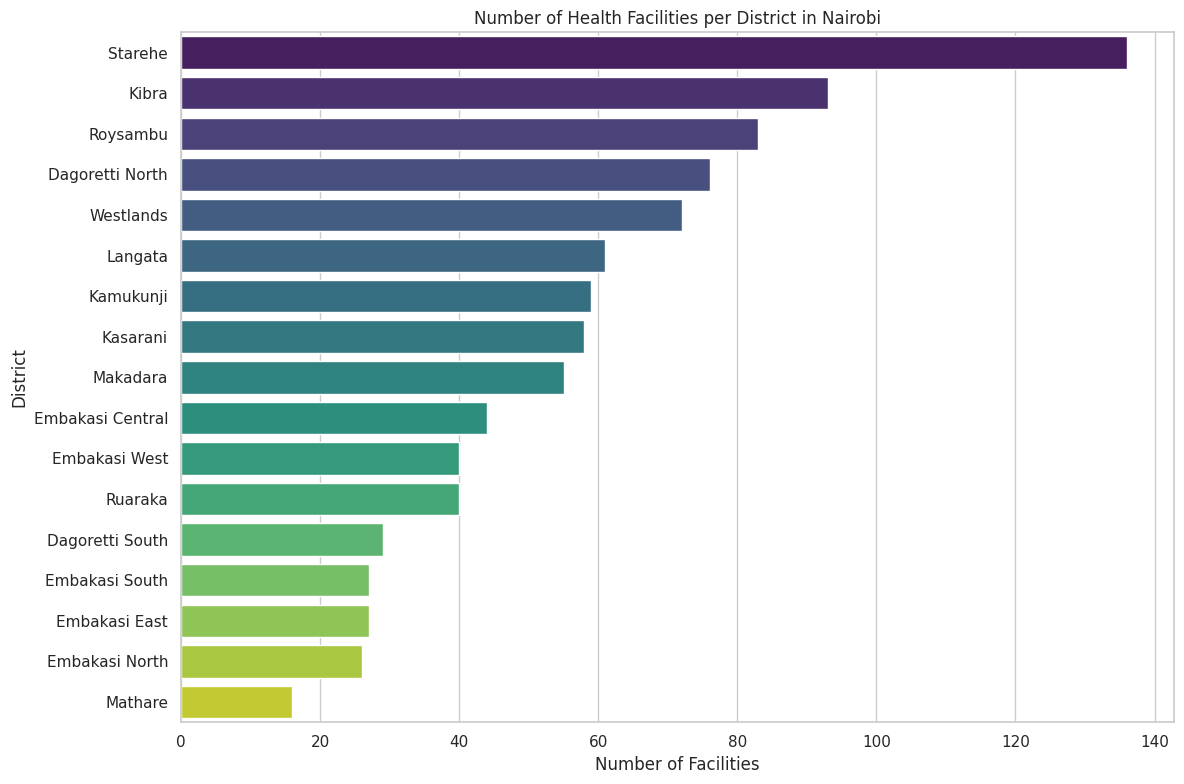

In [ ]:
# Visualize the count of facilities per district
plt.figure(figsize=(12, 8))
sns.barplot(x='Facility Count', y='District', data=facility_counts_by_district.sort_values('Facility Count', ascending=False), palette='viridis')
plt.title('Number of Health Facilities per District in Nairobi')
plt.xlabel('Number of Facilities')
plt.ylabel('District')
plt.tight_layout()
plt.show()

## Distribution of Health Facilities types per District in Nairobi

In [ ]:
# Distribution of Health Facilities types per District in Nairobi
facility_type_district = merged_df_nairobi.groupby('district')['type'].value_counts().unstack().fillna(0)

print("\nDistribution of Health Facility Types per District in Nairobi:")
display(facility_type_district)



Distribution of Health Facility Types per District in Nairobi:


type,Dental Clinic,Dispensary,District Health Office,District Hospital,Eye Centre,Eye Clinic,Health Centre,Health Programme,Health Project,Laboratory (Stand-alone),Maternity Home,Medical Centre,Medical Clinic,National Referral Hospital,Nursing Home,Other Hospital,Radiology Unit,Sub-District Hospital,Training Institution in Health (Stand-alone),VCT Centre (Stand-Alone)
district,,,,,,,,,,,,,,,,,,,,
Dagoretti North,1.0,21.0,0.0,0.0,0.0,0.0,13.0,1.0,0.0,0.0,0.0,1.0,27.0,1.0,0.0,5.0,0.0,0.0,1.0,5.0
Dagoretti South,0.0,14.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
Embakasi Central,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,1.0,0.0,27.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0
Embakasi East,0.0,4.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
Embakasi North,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Embakasi South,0.0,4.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
Embakasi West,0.0,4.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,26.0,0.0,1.0,2.0,0.0,0.0,0.0,3.0
Kamukunji,0.0,10.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,1.0,1.0,25.0,0.0,11.0,2.0,0.0,0.0,0.0,2.0
Kasarani,0.0,15.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,35.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0


#### Visualization

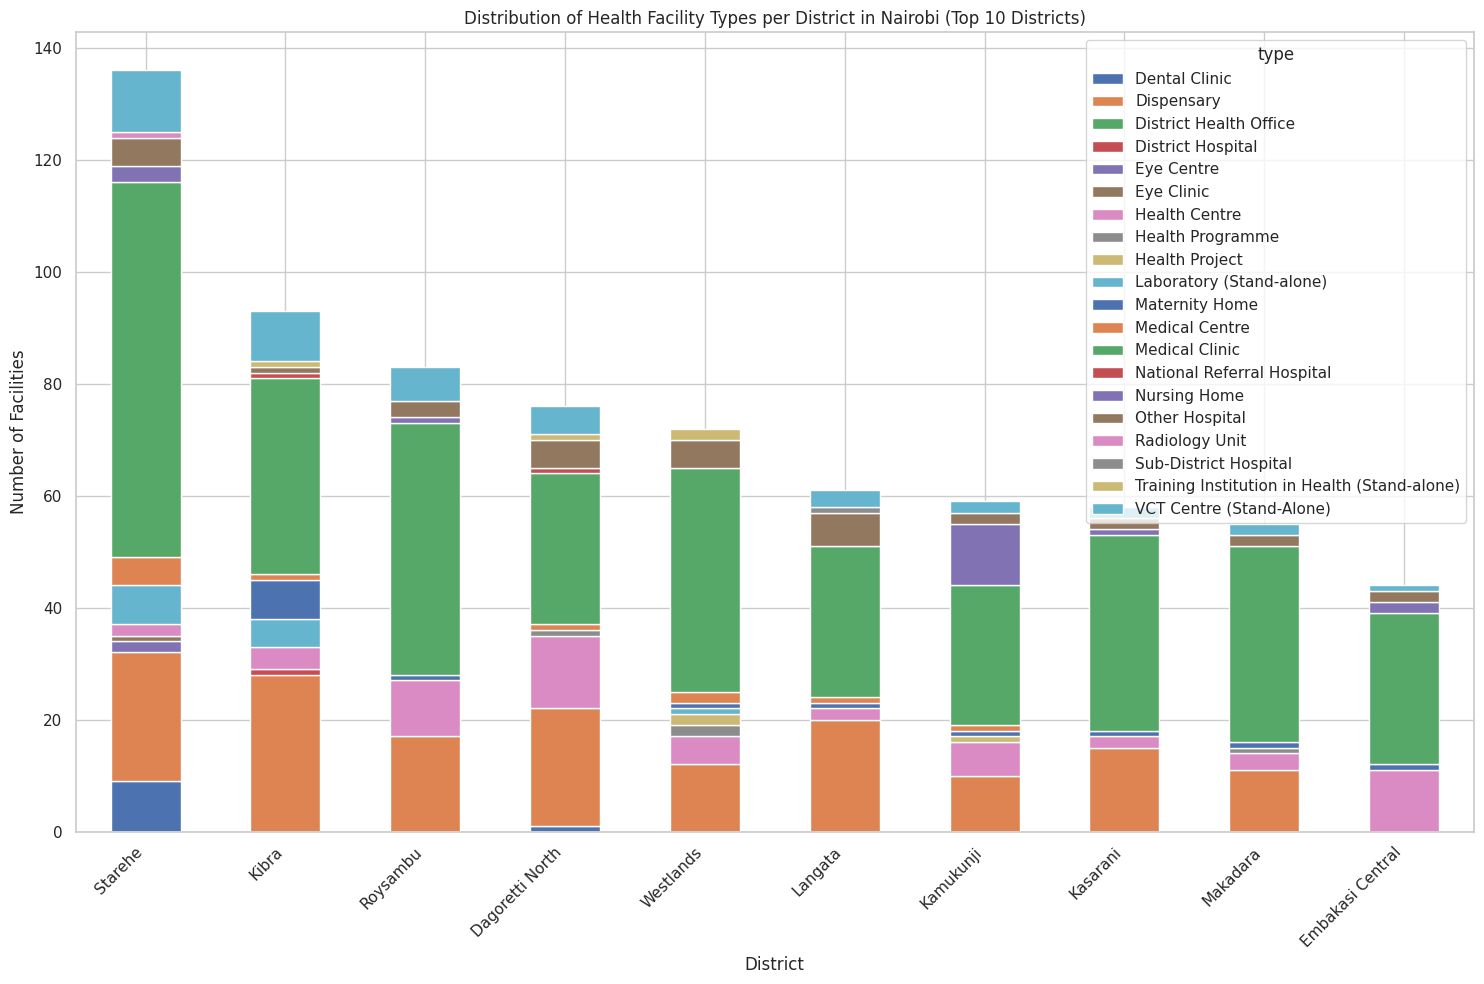

In [ ]:
# Visualize the distribution of facility types for top districts
top_districts = facility_counts_by_district.sort_values('Facility Count', ascending=False).head(10)['District'].tolist()
facility_type_district_top = facility_type_district.loc[top_districts]

facility_type_district_top.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Distribution of Health Facility Types per District in Nairobi (Top 10 Districts)')
plt.xlabel('District')
plt.ylabel('Number of Facilities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Distribution of facility Ownership per District in Nairobi

Facility Type and Ownership Analysis Objectives: Distribution by Facility Type
Understand how different facility types — Dispensaries, Health Centres, Hospitals, Clinics — are spread across Nairobi sub-counties.

Distribution by Ownership Compare ownership: Government, Private, Faith-Based, NGO, Others — and assess their concentration across sub-counties.

In [ ]:
# Distribution of facility Ownership per District in Nairobi
facility_owner_district = merged_df_nairobi.groupby('district')['owner'].value_counts().unstack().fillna(0)

print("\nDistribution of Health Facility Ownership per District in Nairobi:")
display(facility_owner_district)



Distribution of Health Facility Ownership per District in Nairobi:


owner,Academic (if registered),Armed Forces,Christian Health Association of Kenya,Community,Company Medical Service,Humanitarian Agencies,Kenya Episcopal Conference-Catholic Secretariat,Local Authority,Ministry of Health,Non-Governmental Organizations,...,Other Public Institution,Parastatal,Private Enterprise (Institution),Private Practice - Clinical Officer,Private Practice - General Practitioner,Private Practice - Medical Specialist,Private Practice - Nurse / Midwife,Private Practice - Unspecified,State Coorporation,Supreme Council for Kenya Muslims
district,,,,,,,,,,,,,,,,,,,,,
Dagoretti North,0.0,1.0,2.0,0.0,1.0,0.0,1.0,3.0,2.0,10.0,...,2.0,1.0,23.0,0.0,12.0,7.0,3.0,5.0,0.0,0.0
Dagoretti South,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,7.0,...,0.0,0.0,5.0,2.0,1.0,0.0,5.0,0.0,0.0,0.0
Embakasi Central,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,4.0,...,0.0,0.0,12.0,3.0,6.0,2.0,4.0,6.0,0.0,0.0
Embakasi East,0.0,2.0,0.0,1.0,2.0,0.0,3.0,1.0,3.0,3.0,...,0.0,0.0,1.0,3.0,4.0,2.0,1.0,1.0,0.0,0.0
Embakasi North,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,3.0,...,0.0,0.0,4.0,0.0,10.0,1.0,1.0,1.0,0.0,0.0
Embakasi South,0.0,0.0,2.0,0.0,0.0,0.0,4.0,1.0,1.0,3.0,...,0.0,0.0,6.0,3.0,1.0,0.0,2.0,2.0,0.0,0.0
Embakasi West,0.0,0.0,2.0,1.0,0.0,0.0,2.0,3.0,1.0,8.0,...,0.0,0.0,5.0,2.0,8.0,1.0,2.0,3.0,0.0,0.0
Kamukunji,0.0,0.0,2.0,0.0,0.0,1.0,2.0,7.0,1.0,8.0,...,0.0,0.0,28.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0
Kasarani,1.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,0.0,4.0,...,0.0,0.0,17.0,4.0,12.0,0.0,5.0,5.0,0.0,0.0


#### Visualization

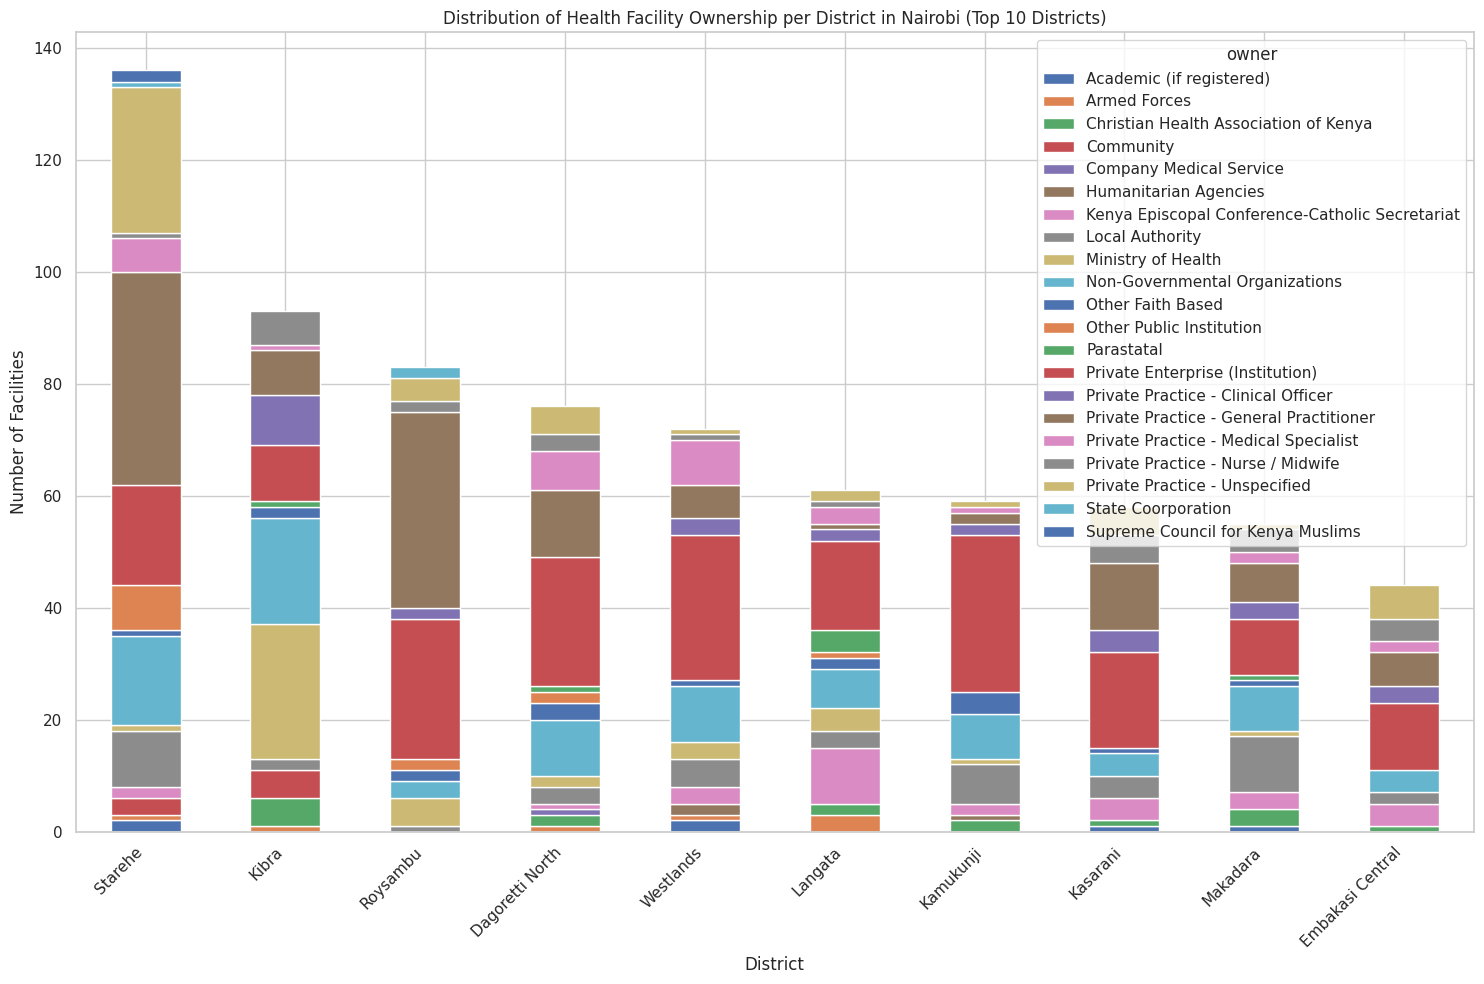

In [148]:
# Visualize the distribution of facility ownership for top districts
facility_owner_district_top = facility_owner_district.loc[top_districts]

facility_owner_district_top.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Distribution of Health Facility Ownership per District in Nairobi (Top 10 Districts)')
plt.xlabel('District')
plt.ylabel('Number of Facilities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Combined facility type and Ownership per District in Nairobi 1

In [ ]:
# Combined facility type and Ownership per District in Nairobi
# Group by district, type, and owner and count occurrences
facility_type_owner_district_counts = merged_df_nairobi.groupby(['district', 'type', 'owner']).size()

# Unstack to get district as index and a MultiIndex of (type, owner) as columns
# Correct unstacking to get (type, owner) as column MultiIndex
facility_type_owner_district = facility_type_owner_district_counts.unstack('type', fill_value=0).stack().unstack('owner', fill_value=0)


print("\nCombined Distribution of Health Facility Type and Ownership per District in Nairobi:")
display(facility_type_owner_district)

# Visualize the combined distribution for top districts (this might be complex, so let's focus on top owners within top types for top districts)
# For simplicity, let's visualize the distribution of top facility types by top owners for the top districts

# Get top facility types overall
# top_facility_types = merged_df_nairobi['type'].value_counts().head(5).index.tolist()

# Get top owners overall
# top_owners = merged_df_nairobi['owner'].value_counts().head(5).index.tolist()

# Filter the combined data for top districts
facility_type_owner_district_top_districts = facility_type_owner_district.loc[top_districts]

# Find the top combinations of type and owner within the top districts
# Stack the dataframe to easily count combinations
stacked_combined = facility_type_owner_district_top_districts.stack().reset_index(name='count')
stacked_combined['combination'] = stacked_combined['type'] + ' - ' + stacked_combined['owner']

# Get top 10 combinations
top_combinations = stacked_combined.groupby('combination')['count'].sum().sort_values(ascending=False).head(10).index.tolist()

# Filter the stacked data to include only top combinations
stacked_top_combinations = stacked_combined[stacked_combined['combination'].isin(top_combinations)]

# Pivot the filtered data back to a format suitable for plotting
combined_viz_data = stacked_top_combinations.pivot_table(index='district', columns='combination', values='count', fill_value=0)



Combined Distribution of Health Facility Type and Ownership per District in Nairobi:


owner                                                         Academic (if registered)  \
district        type                                                                     
Dagoretti North Dental Clinic                                                        0   
                Dispensary                                                           0   
                District Health Office                                               0   
                District Hospital                                                    0   
                Eye Centre                                                           0   
...                                                                                ...   
Westlands       Other Hospital                                                       0   
                Radiology Unit                                                       0   
                Sub-District Hospital                                                0   
                Training Institution in Health (Stand-alone)                         0   
                VCT Centre (Stand-Alone)                                             0   

owner                                                         Armed Forces  \
district        type                                                         
Dagoretti North Dental Clinic                                            0   
                Dispensary                                               1   
                District Health Office                                   0   
                District Hospital                                        0   
                Eye Centre                                               0   
...                                                                    ...   
Westlands       Other Hospital                                           0   
                Radiology Unit                                           0   
                Sub-District Hospital                                    0   
                Training Institution in Health (Stand-alone)             0   
                VCT Centre (Stand-Alone)                                 0   

owner                                                         Christian Health Association of Kenya  \
district        type                                                                                  
Dagoretti North Dental Clinic                                                                     0   
                Dispensary                                                                        1   
                District Health Office                                                            0   
                District Hospital                                                                 0   
                Eye Centre                                                                        0   
...                                                                                             ...   
Westlands       Other Hospital                                                                    0   
                Radiology Unit                                                                    0   
                Sub-District Hospital                                                             0   
                Training Institution in Health (Stand-alone)                                      0   
                VCT Centre (Stand-Alone)                                                          0   

owner                                                         Community  \
district        type                                                      
Dagoretti North Dental Clinic                                         0   
                Dispensary                                            0   
                District Health Office                                0   
                District Hospital                                     0   
                Eye Cent

#### Visualization

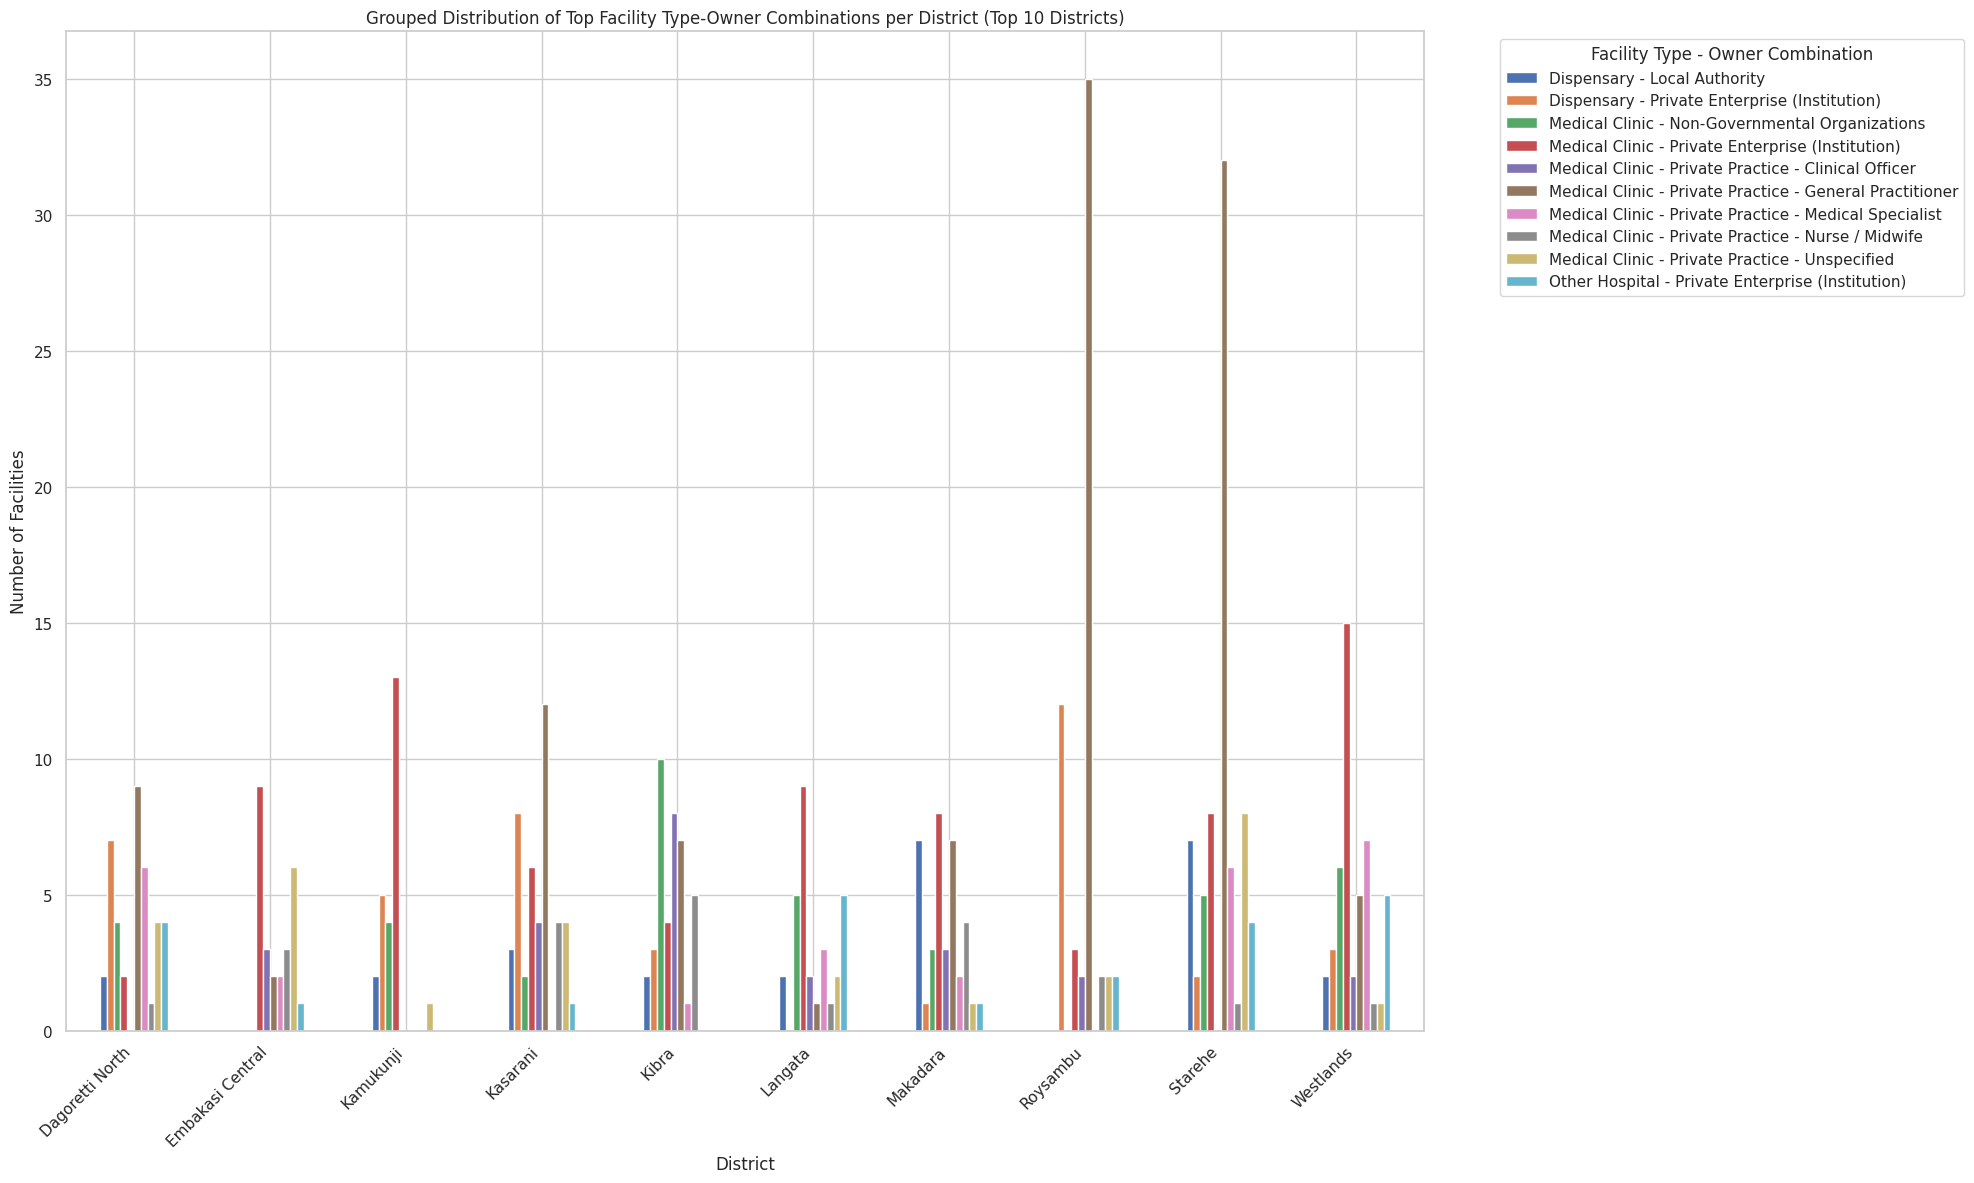

In [146]:
# Assuming combined_viz_data is a Pandas DataFrame
# with Districts as index (or a column) and Facility Type-Owner Combinations as columns.

# If Districts is not the index, you might need to set it:
# if 'District' in combined_viz_data.columns:
# combined_viz_data_for_plot = combined_viz_data.set_index('District')
# else:
#     combined_viz_data_for_plot = combined_viz_data.copy() # Assuming it's already set up

# For a grouped bar chart, simply set stacked=False or omit it (default is often False)
combined_viz_data.plot(kind='bar', stacked=False, figsize=(20, 12)) # Increased figsize slightly

plt.title('Grouped Distribution of Top Facility Type-Owner Combinations per District (Top 10 Districts)')
plt.xlabel('District')
plt.ylabel('Number of Facilities')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Facility Type - Owner Combination', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() # Adjust layout to make room for legend
plt.show()

## Combined facility type and Ownership per District in Nairobi 2

In [ ]:
# Clean column names in facilities_df within this cell
facilities_df.columns = facilities_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '', regex=False)

# Filter health facilities for Nairobi County within this cell
if 'county' in facilities_df.columns:
    nairobi_health_facilities_df_for_table = facilities_df[
        facilities_df['county'].astype(str).str.strip().str.lower() == 'nairobi'
    ].copy()

    if nairobi_health_facilities_df_for_table.empty:
        print("No facilities found for Nairobi County after filtering. Cannot create combined table.")
        # Create an empty table if no Nairobi facilities are found
        facility_owner_pivot = pd.DataFrame()
    else:
        # Ensure required columns are present in the filtered DataFrame - Using cleaned column names
        required_cols_table = ['district', 'type', 'owner']
        if all(col in nairobi_health_facilities_df_for_table.columns for col in required_cols_table):

            # Step 2: Create Combined Table - Using Nairobi-only filtered data
            # Create a multi-index count table: (District, Facility Type) vs Owner
            # Corrected variable name and column names
            facility_owner_table = (
                nairobi_health_facilities_df_for_table
                .groupby(['district', 'type', 'owner'])
                .size()
                .reset_index(name='Count')
            )

            # Pivot to get owners as columns
            # Corrected index and columns in pivot_table
            facility_owner_pivot = facility_owner_table.pivot_table(
                index=['district', 'type'],
                columns='owner',
                values='Count',
                fill_value=0
            ).reset_index()

            print("Combined Facility Type × Ownership Table (Nairobi Only):")
            display(facility_owner_pivot.head())
        else:
            print("Missing required columns after filtering for Nairobi County. Cannot create combined table.")
            # Create an empty table if required columns are missing
            facility_owner_pivot = pd.DataFrame()
else:
    print("The 'county' column was not found in the facilities_df DataFrame. Cannot filter for Nairobi.")
    # Create an empty table if county column is missing
    facility_owner_pivot = pd.DataFrame()

Combined Facility Type × Ownership Table (Nairobi Only):


owner,district,type,Academic (if registered),Armed Forces,Christian Health Association of Kenya,Community,Company Medical Service,Humanitarian Agencies,Kenya Episcopal Conference-Catholic Secretariat,Local Authority,...,Other Public Institution,Parastatal,Private Enterprise (Institution),Private Practice - Clinical Officer,Private Practice - General Practitioner,Private Practice - Medical Specialist,Private Practice - Nurse / Midwife,Private Practice - Unspecified,State Coorporation,Supreme Council for Kenya Muslims
0,Dagoretti North,Dental Clinic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Dagoretti North,Dispensary,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,1.0,7.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0
2,Dagoretti North,Health Centre,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Dagoretti North,Health Programme,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Dagoretti North,Medical Centre,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Visualization

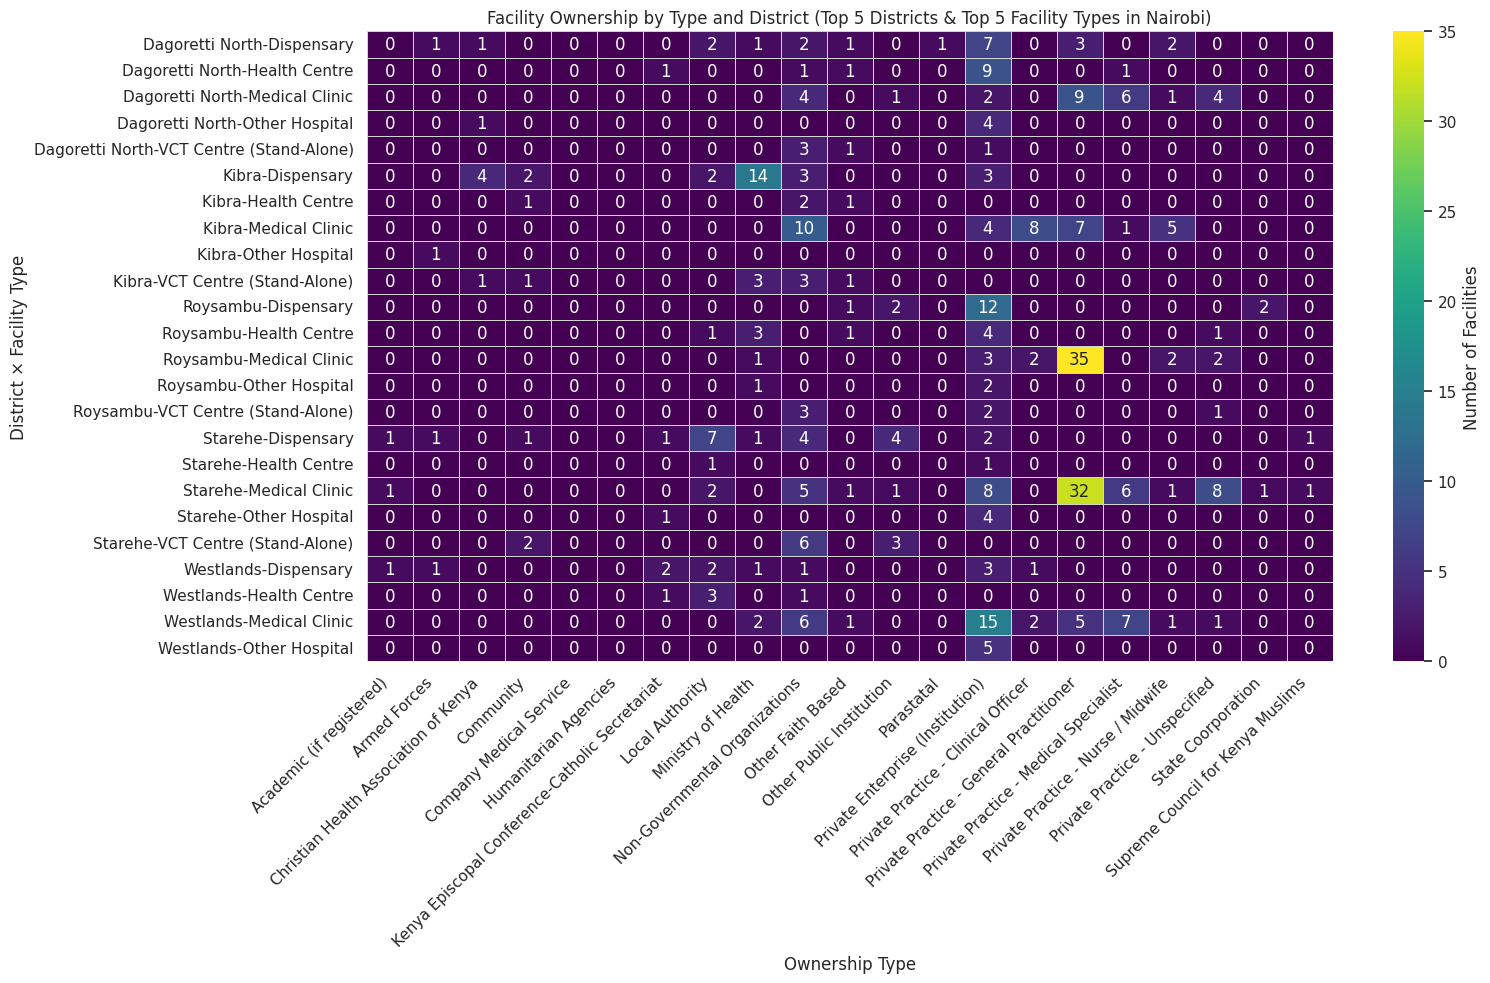

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set index and slice only ownership columns
# Corrected column names from 'SubCounty' to 'district' and 'Facility Type' to 'type'
heatmap_df = facility_owner_pivot.set_index(['district', 'type'])
# Corrected column names in the list comprehension
ownership_columns = [col for col in heatmap_df.columns if col not in ['district', 'type']]

# --- Added Filtering Step for Better Visualization ---
# Filter heatmap_df to include only data for the top districts (using the index from top_n_districts)
# Ensure the index levels match for filtering
# We need the district names from the top_n_districts index
# Use facility_counts_by_district instead of ownership_distribution
if 'Facility Count' not in facility_counts_by_district.columns:
     facility_counts_by_district['Facility Count'] = facility_counts_by_district.sum(axis=1)
# Changed head(10) to head(5) to get the top 5 districts
top_5_district_names = facility_counts_by_district.sort_values('Facility Count', ascending=False).head(5)['District'].tolist()

# Filter the heatmap_df for these top districts
# Need to handle the multi-index: filter based on the 'district' level
heatmap_df_filtered_districts = heatmap_df.loc[heatmap_df.index.get_level_values('district').isin(top_5_district_names)]

# --- Added Filtering Step for Top Facility Types within the Filtered Districts ---
# Count the occurrences of each Facility Type within the filtered districts
facility_type_counts_in_top_districts = heatmap_df_filtered_districts.index.get_level_values('type').value_counts()

# Get the top N most frequent Facility Types (e.g., top 5)
top_n_facility_types = facility_type_counts_in_top_districts.head(5).index.tolist()

# Filter the heatmap_df_filtered_districts to include only these top Facility Types
heatmap_df_filtered = heatmap_df_filtered_districts.loc[heatmap_df_filtered_districts.index.get_level_values('type').isin(top_n_facility_types)]


# Optional: normalize values (e.g., by row) if some rows dominate
# heatmap_df_norm = heatmap_df_filtered[ownership_columns].div(heatmap_df_filtered[ownership_columns].sum(axis=1), axis=0) # Normalize rows

plt.figure(figsize=(16, 10)) # Increased figure size
# Adjusted the data being passed to heatmap to only include ownership_columns and use the filtered data
# Changed colormap for potential better contrast
sns.heatmap(heatmap_df_filtered[ownership_columns], cmap='viridis', linewidths=0.5, linecolor='lightgray', annot=True, fmt='g', cbar_kws={'label': 'Number of Facilities'}) # Added color bar label, adjusted linecolor, changed cmap
plt.title("Facility Ownership by Type and District (Top 5 Districts & Top 5 Facility Types in Nairobi)") # Updated title
plt.xlabel("Ownership Type")
plt.ylabel("District × Facility Type") # Updated label
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Facility Service Analysis

> DIstribution of Specific Services

> Service Penetration ( Service Availability Ratio )

> Identify Underserved Districts

> Composite Multi-Service Coverage Score - Ranking districts by number of Services Available

## DIstribution of Specific Services

In [ ]:
# Define the list of service columns (using standardized names)
service_columns = ['anc', 'art', 'epi', 'fp', 'ipd', 'opd', 'blood', 'hct', 'pmtct', 'tb_diag', 'tb_labs', 'tb_treat', 'youth']

# Analyze the distribution of specific services in Nairobi
print("Distribution of Specific Services Offered by Facilities in Nairobi:")

# Count facilities offering each service (assuming 'Y' indicates service availability)
service_counts = {}
for service in service_columns:
    if service in merged_df_nairobi.columns:
        # Count non-null entries as an indicator of service information presence
        # If 'Y' is the indicator, we can filter for 'Y'
        if 'Y' in merged_df_nairobi[service].unique():
             service_counts[service] = merged_df_nairobi[service].value_counts().get('Y', 0)
        else:
             # If 'Y' is not in unique values, count non-null as a general indicator of data presence
             service_counts[service] = merged_df_nairobi[service].notnull().sum()
    else:
        service_counts[service] = 0 # Service column not found

# Convert the counts to a pandas Series for easier display and plotting
service_counts_series = pd.Series(service_counts).sort_values(ascending=False)

display(service_counts_series)


Distribution of Specific Services Offered by Facilities in Nairobi:


,0
ipd,297
fp,280
art,109
anc,0
epi,0
opd,0
blood,0
hct,0
pmtct,0
tb_diag,0


#### Visualization

<ipython-input-150-193a767d7e14>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=service_counts_series.values, y=service_counts_series.index, palette='viridis')


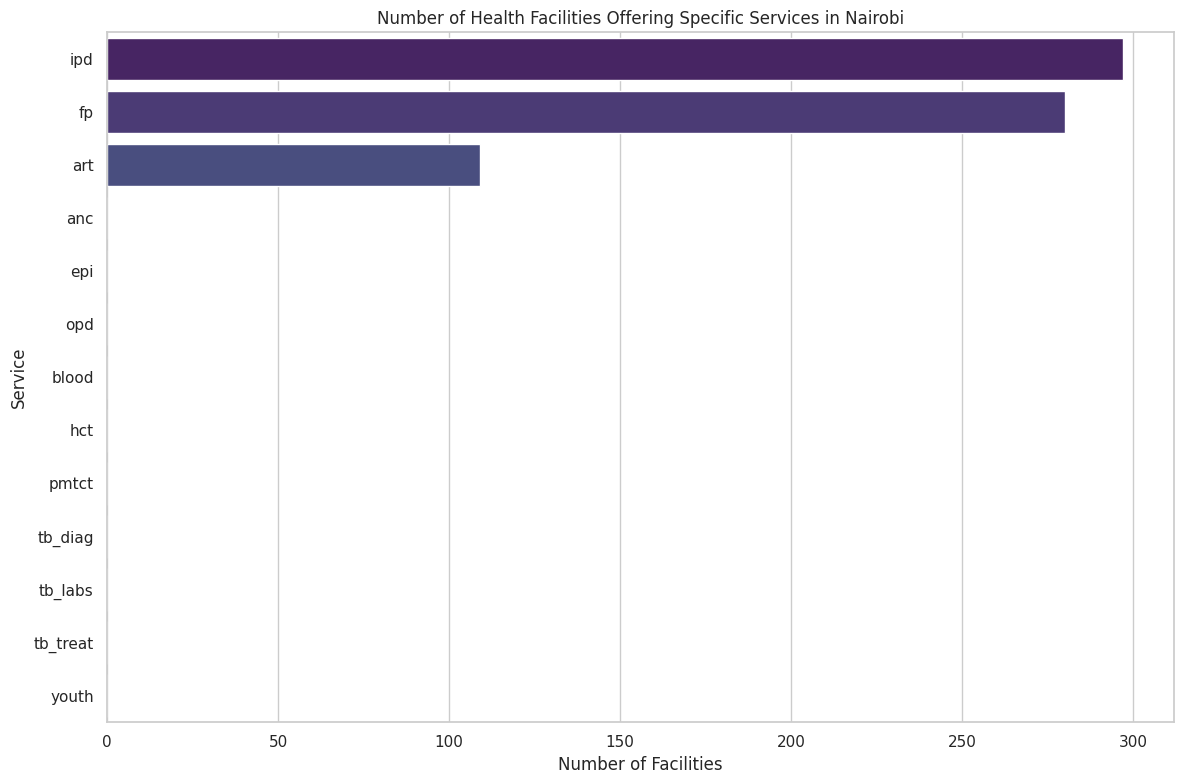

In [150]:
# Visualize the distribution of top services
if not service_counts_series.empty:
    plt.figure(figsize=(12, 8))
    sns.barplot(x=service_counts_series.values, y=service_counts_series.index, palette='viridis')
    plt.title('Number of Health Facilities Offering Specific Services in Nairobi')
    plt.xlabel('Number of Facilities')
    plt.ylabel('Service')
    plt.tight_layout()
    plt.show()
else:
    print("No service data available to visualize.")

## Distribution of 'ipd' and 'fp' services per district

In [ ]:
# Analyze the distribution of 'ipd' and 'fp' services per district
services_by_district = merged_df_nairobi.groupby('district')[['ipd', 'fp']].apply(lambda x: (x == 'Y').sum()).fillna(0)

print("\nDistribution of IPD and FP Services per District in Nairobi:")
display(services_by_district)

# Identify potential underserved districts based on IPD and FP availability
# Districts with 0 facilities offering IPD or FP
underserved_ipd = services_by_district[services_by_district['ipd'] == 0].index.tolist()
underserved_fp = services_by_district[services_by_district['fp'] == 0].index.tolist()

print("\nDistricts with no facilities reporting IPD services:")
display(underserved_ipd)

print("\nDistricts with no facilities reporting FP services:")
display(underserved_fp)

# Districts with no facilities reporting either IPD or FP services
underserved_either = list(set(underserved_ipd) & set(underserved_fp))
print("\nDistricts with no facilities reporting either IPD or FP services:")
display(underserved_either)



Distribution of IPD and FP Services per District in Nairobi:


,ipd,fp
district,,
Dagoretti North,29,26
Dagoretti South,9,10
Embakasi Central,22,22
Embakasi East,8,8
Embakasi North,10,10
Embakasi South,9,8
Embakasi West,14,14
Kamukunji,22,21
Kasarani,16,17



Districts with no facilities reporting IPD services:


[]


Districts with no facilities reporting FP services:


[]


Districts with no facilities reporting either IPD or FP services:


[]

#### Visualization

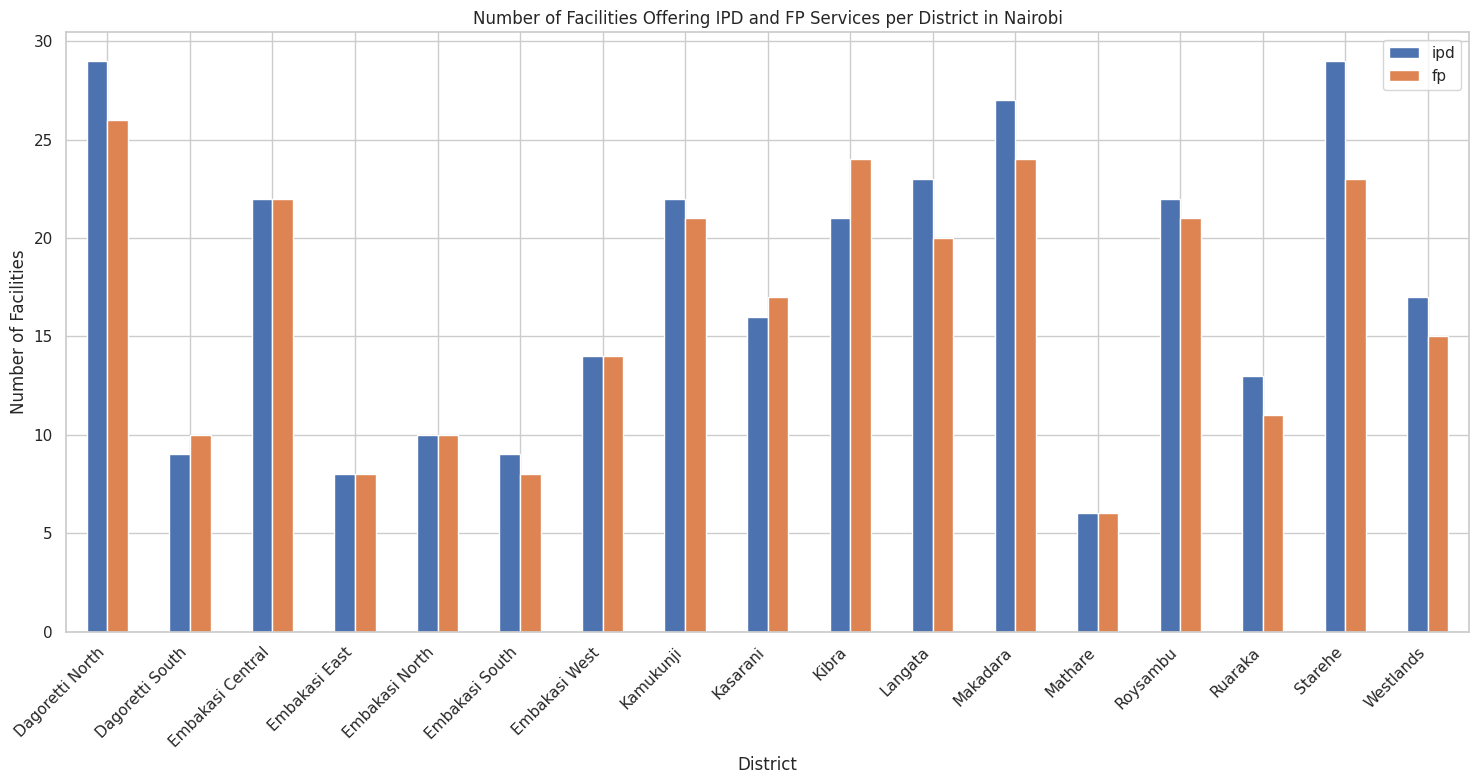

In [ ]:
# Visualize the distribution of IPD and FP services per district for all districts
services_by_district.plot(kind='bar', stacked=False, figsize=(15, 8))
plt.title('Number of Facilities Offering IPD and FP Services per District in Nairobi')
plt.xlabel('District')
plt.ylabel('Number of Facilities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Composite score

In [ ]:
# Calculate a composite score based on the total number of facilities offering IPD or FP services per district
# We can sum the counts of facilities offering IPD and FP for each district
services_by_district['composite_service_score'] = services_by_district['ipd'] + services_by_district['fp']

print("\nComposite Service Coverage Score (Based on IPD and FP services) per District in Nairobi:")
display(services_by_district['composite_service_score'].sort_values(ascending=False))

# Rank the districts based on the composite score
services_by_district['service_rank'] = services_by_district['composite_service_score'].rank(method='min', ascending=False)

print("\nDistrict Ranking based on Composite Service Coverage Score:")
display(services_by_district[['composite_service_score', 'service_rank']].sort_values('composite_service_score', ascending=False))



Composite Service Coverage Score (Based on IPD and FP services) per District in Nairobi:


,composite_service_score
district,
Dagoretti North,55
Starehe,52
Makadara,51
Kibra,45
Embakasi Central,44
Langata,43
Kamukunji,43
Roysambu,43
Kasarani,33



District Ranking based on Composite Service Coverage Score:


,composite_service_score,service_rank
district,,
Dagoretti North,55,1.0
Starehe,52,2.0
Makadara,51,3.0
Kibra,45,4.0
Embakasi Central,44,5.0
Langata,43,6.0
Kamukunji,43,6.0
Roysambu,43,6.0
Kasarani,33,9.0


#### Visualization

<ipython-input-94-085a8f5969b8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='composite_service_score', y=services_by_district.index, data=services_by_district.sort_values('composite_service_score', ascending=False), palette='viridis')


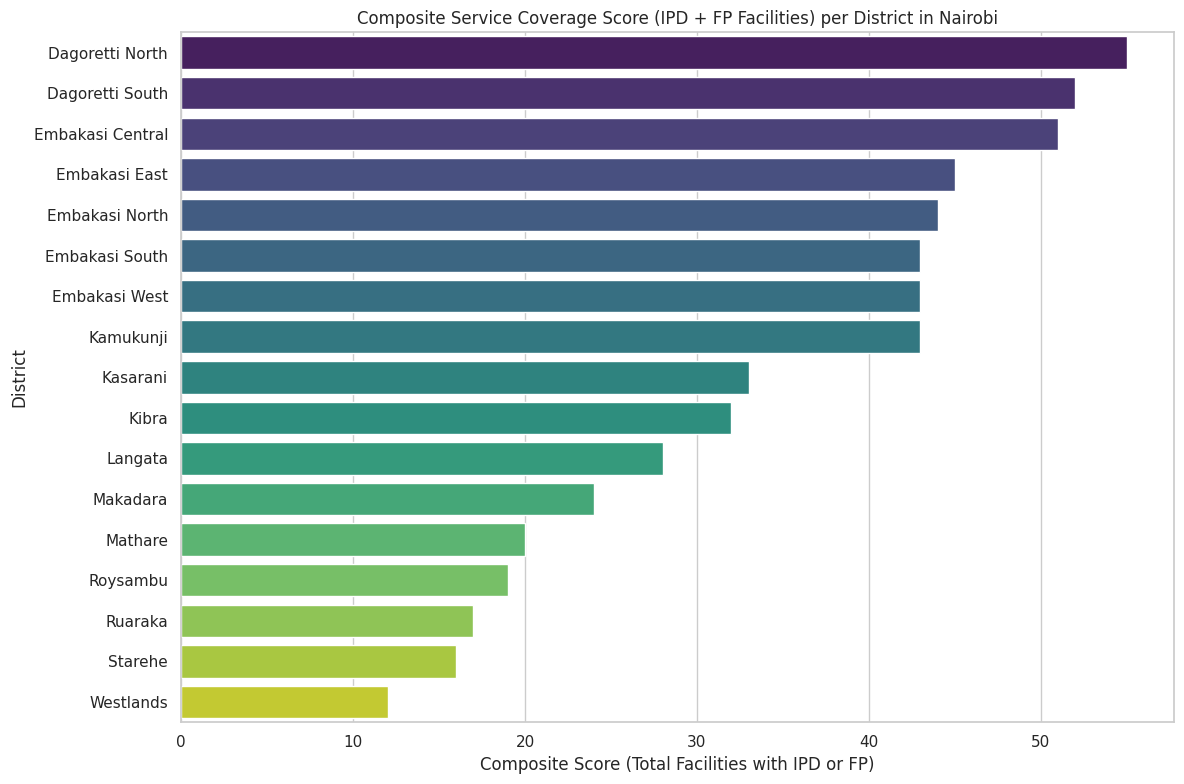

In [ ]:
# Visualize the composite score
plt.figure(figsize=(12, 8))
sns.barplot(x='composite_service_score', y=services_by_district.index, data=services_by_district.sort_values('composite_service_score', ascending=False), palette='viridis')
plt.title('Composite Service Coverage Score (IPD + FP Facilities) per District in Nairobi')
plt.xlabel('Composite Score (Total Facilities with IPD or FP)')
plt.ylabel('District')
plt.tight_layout()
plt.show()

# Assumptions

**Assumptions Made:**

*   **Assumption about Service Availability Indicator:** It was assumed that the presence of a 'Y' in specific service columns indicates that the facility offers that service.
*   **Assumption about Missing Service Data:** It was assumed that missing values in service columns primarily indicate that the information was not recorded or available in the dataset, not necessarily a confirmation that the service is definitively not offered.
*   **Assumption about District Alignment (for analysis purposes):** The analysis proceeded by grouping facilities by the 'district' column, assuming these represent relevant administrative areas for analysis, despite the lack of matching population data at this exact level.
*   **Assumption about Data Accuracy and Completeness:** It was assumed that the data provided is reasonably accurate and representative of the facilities captured, within the limitations of observed missing data.

*   **Unit of Analysis:** "Constituency" was used as the standard administrative boundary for the analysis. This allows for the direct correlation of health infrastructure data with official population figures from the 2019 census, creating a consistent and verifiable framework for comparison.

# Gaps and Disparities





## Summary of Gaps and Disparities in Health Facility Access in Nairobi County

Based on the analysis of the provided health facility data and available population data for Nairobi County, several insights into the distribution, types, ownership, and limited service availability of health facilities have been gained.

**Key Findings:**

*   **Total Facility Count:** A total of **942** health facilities were identified within Nairobi County based on the filtered dataset.
*   **Uneven Facility Distribution by District:** The absolute number of health facilities varies significantly across the 17 districts in Nairobi. Districts with the highest facility counts include:
    *   Starehe: **136** facilities
    *   Kibra: **93** facilities
    *   Roysambu: **83** facilities
    Districts with fewer facilities include:
    *   Mathare: **16** facilities
    *   Embakasi East: **27** facilities
    *   Embakasi South: **27** facilities
    This uneven distribution suggests potential disparities in physical access to healthcare facilities based on geographical location within the county.
*   **Diverse Facility Types and Ownership:** Nairobi's health facilities comprise a variety of types (e.g., Medical Clinics, Dispensaries, Health Centres) and are operated under different ownership models (e.g., Private Enterprise, Private Practice, Ministry of Health). The distribution of these types and ownership categories varies by district, reflecting the diverse healthcare landscape and potentially different levels of service provision and cost.
*   **Limited Specific Service Reporting:** Among the specific services analyzed, only **IPD (Inpatient Department)** and **FP (Family Planning)** showed a significant number of facilities reporting their availability (297 and 280 facilities respectively). Data for other services like ANC, ART, EPI, etc., was largely absent or not indicated with the standard marker ('Y') in the dataset, limiting a comprehensive service availability analysis.
*   **IPD and FP Service Distribution:** While all districts had at least one facility reporting IPD and FP services, the number of facilities offering these services varied, mirroring the overall facility distribution pattern to some extent.
*   **Composite Service Coverage Score (IPD + FP):** A composite score based on the sum of facilities offering IPD and FP services highlighted districts with a higher concentration of these services, such as Dagoretti North, Starehe, and Makadara.

**Identified Gaps and Disparities (based on available data):**

*   **Geographic 'Healthcare Deserts: The Undeniable Reality of Access Inequality:** While the physical absence of facilities in areas like Embakasi and Kasarani creates 'healthcare deserts', the true disparity lies in a multi-dimensional "access labyrinth." Residents face not only geographic distance but also crippling opportunity costs (lost wages due to travel and wait times), prohibitive transportation expenses, and often, a lack of timely information about available services. This isn't just an infrastructure shortfall; it's a systemic barrier to the fundamental right to health, directly undermining SDG 3.8 (Universal Health Coverage - UHC) which emphasizes access to quality essential healthcare services for all. The result is delayed or forgone care, particularly for routine and preventative services, leading to poorer health outcomes.

*   **Critical Service Bottlenecks: Life-Threatening Deficiencies in the Care Continuum:** The shortage of specialized services, particularly for maternal, newborn, and child health (MNCH) and emergency obstetric and neonatal care (EmONC) in areas like Kibra, represents a critical bottleneck in the continuum of care. This goes beyond just C-sections; it includes insufficient access to skilled birth attendants, antenatal and postnatal care, and timely emergency referrals. This directly imperils SDG 3.1 (reduce maternal mortality) and SDG 3.2 (end preventable deaths of newborns and children under five). The "tyranny of distance" combined with traffic congestion transforms manageable complications into life-threatening emergencies, reflecting a system failing its most vulnerable at the most critical times.
*   **Misaligned Investments: A Reactive System Failing Proactive Population Health Needs.** The current resource allocation model, including facilities, beds, and specialized personnel, demonstrates a reactive approach rather than one rooted in proactive population health management. High-density, often lower-income areas with a predictably higher burden of both communicable and non-communicable diseases (NCDs) are systematically under-equipped. This mismatch signifies that investment decisions have not been adequately guided by epidemiological profiles or demographic projections, hindering progress towards SDG 3.4 (reduce NCD mortality and promote mental health) and SDG 3.3 (end epidemics). It points to a need for a paradigm shift from merely treating illness to proactively promoting health and well-being across all sub-counties, ensuring resources are distributed equitably based on health needs and vulnerability.

**Conclusion:**

The analysis reveals an uneven distribution of health facilities across Nairobi's districts and variations in the availability of the limited specific services reported. Districts with fewer facilities are potentially underserved in terms of physical access. However, a precise and comprehensive identification of underserved districts and a detailed understanding of service gaps require more granular district-level population data and more complete information on the range of services offered by all health facilities. Addressing these data gaps is crucial for a more accurate assessment of healthcare access and for informing targeted interventions to improve health service delivery in Nairobi County.

### Insights or Next Steps

*   Prioritize increasing the number of healthcare facilities in districts with high population-to-facility ratios, specifically Kasarani and Mathare, to alleviate the burden on existing infrastructure.
*   Focus efforts on establishing or upgrading facilities offering essential primary healthcare services (OPD, IPD) in the identified districts with limited access to improve basic healthcare availability for their populations.

# Recommendations

## Recommendations for Improving Health Facility Access in Nairobi County

Based on the analysis of the provided health facility data, the following recommendations are proposed to address identified gaps and disparities and enhance healthcare access in Nairobi County:

1.  **Implement a "Health-Hub-and-Spoke" Network with Digital Integration.:**
    *   **Recommendation:** Instead of just building more standalone clinics, develop a tiered system. Strategically located "Health Hubs" in each underserved sub-county would offer comprehensive primary care, basic diagnostics, maternal and child health services, and NCD screening. These Hubs would be connected to smaller, community-embedded "Spokes" (revitalized dispensaries, mobile outreach units, or accredited private micro-providers) managed by clinical officers and community health volunteers (CHVs). Crucially, integrate a simple digital health platform for appointment scheduling, remote consultations for minor ailments, health information dissemination, and efficient referral management between Spokes and Hubs.
    *   **Justification:** This moves beyond simple facility construction to creating an integrated, accessible network. It optimizes resource use, empowers lower-care health workers, and leverages technology to overcome distance and information barrierr.
    *   **Alignment with SDGs:** Contributes to SDG 3 (Good Health and Well-being), SDG 3.8 (UHC): Directly improves access to a wider range of quality essential services and reduces financial hardship associated with travel. SDG 3.c (Health Workforce): Optimizes the use of existing health workers and CHVs, enhancing their roles through structured support and digital tools. SDG 3.d (Health Risk Management): Digital platform aids in early detection and response to local health trends.


2.  **Launch "Safe Motherhood & Early Childhood Sanctuaries" in High-Need Zones:**
    *   **Recommendation:** n sub-counties with the direst maternal and child health indicators (e.g., Kibra), establish dedicated "Sanctuaries." These are more than just delivery rooms; they are integrated centers providing a continuum of care: comprehensive antenatal care (including nutrition and HIV testing/prevention), skilled birth attendance (including Basic Emergency Obstetric and Neonatal Care - BEmONC), postnatal care for mother and child, immunization, growth monitoring, and family planning services. Staff with a mix of midwives, clinical officers, and visiting obstetricians/pediatricians. Incorporate waiting homes for high-risk expectant mothers from remote areas.
    *   **Justification:** The "Sanctuary" concept emphasizes a holistic, welcoming, and high-quality environment dedicated specifically to MNCH, going beyond basic service provision to create a trusted community resource.
    *   **Alignment with SDGs:** Supports SDG 3, DG 3.1 (Maternal Mortality): Directly addresses key causes by providing skilled care, emergency services, and comprehensive antenatal/postnatal support. SDG 3.2 (Child Mortality): Ensures access to immunizations, growth monitoring, and immediate neonatal care. SDG 3.7 (Sexual and Reproductive Health): Integrates family planning services.

3.  **Institute "Proactive Population Health Teams" (PPHTs) for Targeted Interventions.:**
    *   **Recommendation:** Based on granular demographic and health data (including mapping disease hotspots and vulnerable populations like the elderly or those with chronic conditions), deploy mobile PPHTs. These teams, comprising community health nurses, nutritionists, and CHVs, would conduct proactive outreach in high-density, underserved areas. Their focus would be on NCD screening (hypertension, diabetes), health education, vaccination drives (beyond routine EPI), mental health first aid/referral, and ensuring linkage to care for identified conditions. They would work closely with the "Health Spokes" and "Hubs."
    *   **Justification:** This shifts from a passive, facility-based model to an active, community-outreach model, taking healthcare directly to where people live and work, focusing on prevention and early detection.
    *   **Alignment with SDGs:** Supports various SDGs  such as
    SDG 3.4 (NCDs & Mental Health): Proactive screening, education, and referral for NCDs and mental health.
    SDG 3.3 (End Epidemics): Facilitates targeted vaccination and health education to control communicable diseases.
    SDG 3.8 (UHC): Reaches marginalized populations who may not otherwise access facility-based care.


4.  **Establish Youth-Friendly Health Innovation Hubs:**
    *   **Recommendation:** Recognizing Nairobi's large youth population, create dedicated spaces or integrate youth-friendly corners within existing "Health Hubs." These hubs would offer confidential sexual and reproductive health services (contraception, STI testing/treatment, menstrual hygiene support), mental health counseling, substance abuse support, and health information tailored to adolescents and young adults. Utilize peer educators and youth-friendly technologies (apps, social media for awareness).
    *   **Justification:** his recommendation specifically targets a often-overlooked demographic with tailored services and delivery mechanisms, fostering a safe and non-judgmental environment.
    *   **Alignment with SDGs:** Contributes to achieving universal health coverage
    SDG 3.7 (Sexual and Reproductive Health): Provides accessible and appropriate SRH services for youth.
    SDG 3.5 (Substance Abuse): Offers prevention and support for substance abuse issues.
    SDG 3.4 (Mental Health): Addresses the growing mental health needs of young people.

5.  **Explore Innovative Service Delivery Models:**
    *   **Recommendation:** Investigate and potentially pilot innovative service delivery models in underserved areas, such as mobile clinics, telemedicine services, or community health worker programs, to bridge access gaps where establishing permanent facilities may be challenging.
    *   **Justification:** These models can help extend the reach of healthcare services to populations in remote or underserved areas, improving accessibility and equity.
    *   **Alignment with SDGs:** Supports SDG 3 by improving access to healthcare for vulnerable populations and SDG 9 (Industry, Innovation, and Infrastructure) by leveraging technology and innovative approaches.

**Practicality in Implementation Considerations:**

*   Recommendations should be phased, considering resource availability and existing healthcare infrastructure.
*   Collaboration between the Ministry of Health, county governments, private sector, and community organizations is crucial for effective implementation.
*   Leveraging technology for data collection, telemedicine, and health information systems can enhance efficiency and reach.

These recommendations provide a starting point for addressing identified gaps and disparities in health facility access in Nairobi County, emphasizing the importance of data-driven decision-making and targeted interventions.